The singular value decomposition in a nutshell
=============================


## Matrix decompositions

Matrix decomposition is a ubiquitous technique in mathematics with a wide variety of practical and theoretical applications. Here a matrix is decomposed or factorized as the product of two or more matrices where the factors satisfy some desirable properties, depending on the nature of the original problem. So by matrix decomposition we mean a multiplicative decomposition, not an additive one (although additive decompositions can be also useful in some cases).

For instance the $LU$-decomposition and its variants ($LDU$, $LUP$, $LL^T$) are useful to solve linear equations of the form $Ax = b$, where $A\in\mathbb{R}^{n\times n}$ is a given square matrix, $b\in\mathbb{R}^n$ is a given vector. Here $L$ is a lower triangular matrix with all $1$'s in the diagonal and $U$ is an upper triangular matrix.

By knowing that $A$ can be written as $A = LU$, we can transform the above equation to $LUx = b$ which is equivalent to the system $Ly = b,\ Ux = y$. The solution of this system is fast since $U$ and $L$ are triangular matrices, the computational cost for solving these systems (usually referred as forward and backward substitutions) is $O(n^2)$. The matrices $L$ and $U$ are essentially "by-products" of the Gaussian-elimination, where - loosely speaking - $L$ stores the steps of the elimination process and $U$ stores the resulting matrix after the elimination. So to solve $Ax = b$ using Gaussian elimination directly requires $\frac{2}{3}n^3$ flops, whilst creating $A=LU$ and solving the two triangular systems result in $\frac{2}{3}n^3 + O(n^2)$ flops that have the same magnitude, so it is not clear why this extra effort would make a difference. The gain we obtain is more clear if the task is to solve many linear equations having the same matrix $A$ and only the right hand side $b$ changes. In this case the elimination procedure, that is the creation of the $LU$-decomposition needs to be done only once. Another nice application of this decomposition is to calculate the determinant of $A$. Because of the forms of $L$ and $U$ $$\det(A) = \det(LU) = \det(L)\cdot\det(U) = \det(U) = \prod_{i=1}^nu_{ii},$$ so $\det(A)$ can be calculated in $O(n^3)$ flops as well (instead of using Cramer's rule that has $O(n\cdot n!)$ asymptotic complexity which makes it practically useless).

This decomposition is one of the most widely used matrix decomposition technique used in applied mathematics. However, it is much lesser known in data science than in numerical analysis. The decomposition method that is as widespread in data science as $LU$ in numerical analysis is something else which I would like to introduce in the following sections.

## The singular value decomposition of an arbitrary matrix

What data scientists use quite often is the singular value decomposition which can be found behind linear regression and least square methods, and a useful technical tool for solving linear systems that have no unique solution (Moore-Penrose pseudoinverse), performing principal component analysis, calculating low-rank approximations. There is also a plethora of real world applications of singular value decomposition such as image compression, recommender systems, numerical weather forecast or natural language processing.

In what follows we would like to introduce the concept of the singular value decomposition (SVD for short) and illustrate it by showing some applications.

Let $A\in\mathbb{R}^{n\times m}$ be an arbitrary (not necessarily a square) matrix. It can be complex valued as well, but in the examples we are going to deal with real matrices only. Then there exist matrices $U\in\mathbb{R}^{n\times n}$, $D\in\mathbb{R}^{n\times m}$ and $V\in\mathbb{R}^{m\times m}$, such that $$ A = UDV^*, $$ where $U$ and $V$ are unitary matrices, that is $U^*U = UU^* = I_n$ and $V^*V=VV^*=I_m$ and $D$ is a diagonal matrix, that is $d_{ij}=0$ if $i\ne j$. The star operation means conjugate transpose, that is $(V^*)_{ij} = \overline V_{ji}$, but since we are dealing with real matrices now, this is the same as the transpose of the matrix. The diagonal elements in $D$ are nonnegative numbers, in decreasing order: $d_{ii} = \sigma_i$, $\sigma_1\geq\sigma_2\geq\ldots\geq\sigma_r > \sigma_{r+1} = \ldots = \sigma_{\min(n,m)} = 0$, where $r$ is the rank of the matrix $A$. These $\sigma$ values in the diagonal of $D$ are called the singular values of $A$.

Before we would go into more details, I would like to show how this decomposition can help to compress an image. We will rely on the following property of the SVD-decomposition.

## Low-rank approximations of $A$

Let $k\in\mathbb{N}$ a given natural number, where $k\leq\text{rank}(A)\leq\min\{n, m\}$. What we look for is a matrix $A_k$ having $\text{rank}(A_k) = k$ which is the best approximation of $A$ among the matrices that have rank equals to $k$. To formulate the low-rank approximation problem, we would like to solve the following minimalization problem: $$ \left|\left| A - B \right|\right|_F \to \min !\qquad \mbox{ subject to }\quad B\in\mathbb{R}^{n\times m}, \ \text{rank}(B) = k. $$ Here $\left|\left| X \right|\right|_F$ denotes the Frobenius norm of a matrix $X$ which is the squareroot of the sum of squares of the elements of $X$.

The solution of this problem can be obtained from the SVD-decomposition of $A$. If $A = UDV^*$, then we keep the first $k$ values in $D$ as is and set the subsequent singular values to zero. Let us denote the resulting diagonal matrix by $D_k$. It is easy to see that we only have to keep the first $k$ columns of $U$ and the first $k$ rows of $V$, since their other columns would be multiplied by zeros anyway. To sum up, the matrix $A_k := U_kD_kV_k^*$ is the closest matrix to $A$ (in Frobenius norm) having rank $k$, where $U_k$ and $V_k$ consist of the first $k$ columns and rows of $U$ and $V$, respectively.

How can this knowledge be useful? Well, if $A$ is a large matrix, that is $n,m$ are large and $k$ is relatively small, then the information we need to store to approximate the information content stored in $A$ is much smaller. That is, we can reduce the storage space significantly and we are still able to store almost the same information that the original matrix has.

## Welcome to the lab

I would like to stop here, as the number of mathematical expression becomes intractable, and let's do some experiments with a computer. We will see how the SVD-decomposition can be created in Python, how to compute the best k-rank approximation of a matrix and later we will see how to use this machinery to compress an image.


### Illustrating the SVD-decomposition

First I would like to illustrate the above concepts on a toy example. We define a matrix of size $4\times 2$ having rank $2$, and we create its rank-$1$ approximation using the SVD-decomposition.

In [1]:
from __future__ import division

import numpy as np
from numpy import linalg as LA

In [4]:
A = np.array([[1, 2, 0, 0, 2, 3, -1, -2]]).reshape((4, 2))
print A

[[ 1  2]
 [ 0  0]
 [ 2  3]
 [-1 -2]]


The matrix $A$ has rank $2$ since its columns are linearly independent, but if $A[2,1]$ would be $4$ instead of $3$, the rank would be $1$.

In [9]:
n, m = A.shape
rank_A = LA.matrix_rank(A)

print "rows:", n, "columns:", m
print "the rank of A is", rank_A

rows: 4 columns: 2
The rank of A is 2


The built-in function that computes the SVD-decomposition lives in the numpy.linalg library. It returns the matrices $U$ and $V^*$ and the diagonal matrix as a vector $d$ containing the nonzero singular values. 

In [24]:
U, d, V_T = LA.svd(A)
number_of_singular_values = len(d)
print "number of singular values:", number_of_singular_values

number of singular values: 2


In order to restore $A$ from its pieces we create a diagonal matrix $D$ from the vector $d$ that has the proper size. Then the product $UDV^*$ gives back the original matrix $A$ (up to round-off errors).

In [25]:
D = np.concatenate((np.diag(d), np.zeros((n - number_of_singular_values, m))))
A_restored = np.dot(U, np.dot(D, V_T))

In [40]:
np.allclose(A, A_restored, rtol=1e-14, atol=1e-15)

True

In [41]:
np.abs(A - A_restored)

array([[  2.22044605e-16,   2.22044605e-15],
       [  0.00000000e+00,   0.00000000e+00],
       [  4.44089210e-16,   1.77635684e-15],
       [  0.00000000e+00,   8.88178420e-16]])

### Illustrating low-rank approximation

We mentioned that $A$ is "almost" a one-rank matrix, slightly changing one of its element would reduce its rank by $1$. So define a rank one matrix $B$ that has the same elements as $A$ with one exception.

In [43]:
B = np.array([[1, 2, 0, 0, 2, 4, -1, -2]]).reshape((4, 2))
print B

[[ 1  2]
 [ 0  0]
 [ 2  4]
 [-1 -2]]


In [44]:
rank_B = LA.matrix_rank(B)
distance = LA.norm(A - B, "fro")

print "the rank of B is", rank_B
print "the Frobenius-norm of the difference matrix A-B is", distance

the rank of B is 1
the Frobenius-norm of the difference matrix A-B is 1.0


Is $B$ the matrix that is closest to $A$ among all matrices that have rank $1$? To answer this question, let's compute the rank $1$ approximation of $A$ using the SVD-decomposition. Since $k=1$, we need to keep $1$ column from $U$ and $1$ row from $V^*$.

In [47]:
U_1 =  U[:, 0:rank_B]
D_1 = D[0:rank_B, 0:rank_B]
V_T_1 = V_T[0:rank_B, :]

In [50]:
A_1 = np.dot(U_1, np.dot(D_1, V_T_1))
print "the best (that is the closest) rank 1 approximation of A is \n", A_1

the best (that is the closest) rank 1 approximation of A is 
[[ 1.13525653  1.9200267 ]
 [ 0.          0.        ]
 [ 1.83240511  3.09909403]
 [-1.13525653 -1.9200267 ]]


In [54]:
dist_from_A_1 = LA.norm(A - A_1, "fro")
print "The Frobenius-norm of the difference matrix A-A_1 is", dist_from_A_1, \
      "which is smaller that in our previous naive attempt."

The Frobenius-norm of the difference matrix A-A_1 is 0.295445070168 which is smaller that in our previous naive attempt.


### Image compression using SVD

The low-rank approximation of a matrix $A$ provides a solution for various problems. Here we would like to show how it can be used to compress an image.

Images are represented in a rectangular array where each element corresponds to the grayscale value for that pixel. For colored images we have a $3$-dimensional array of size $n\times m\times 3$, where $n$ and $m$ represents the number of pixels vertically and horizontally, respectively, and for each pixel we store the intensity for colors red, green and blue.

What we are going to do is to repeat the low-rank approximation procedure above on a larger matrix, that is, we create the low-rank approximation of a matrix that represents an image for each color separately. The resulting $3$-dimensional array will be a good approximation of the original image, as we will see soon.

In [71]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [72]:
%matplotlib inline

In [73]:
image = np.array(Image.open('Castle_hill.jpg'))

In [74]:
image = image / 255
row, col, _ = image.shape
print "pixels: ", row, "*", col

pixels:  1016 * 1600


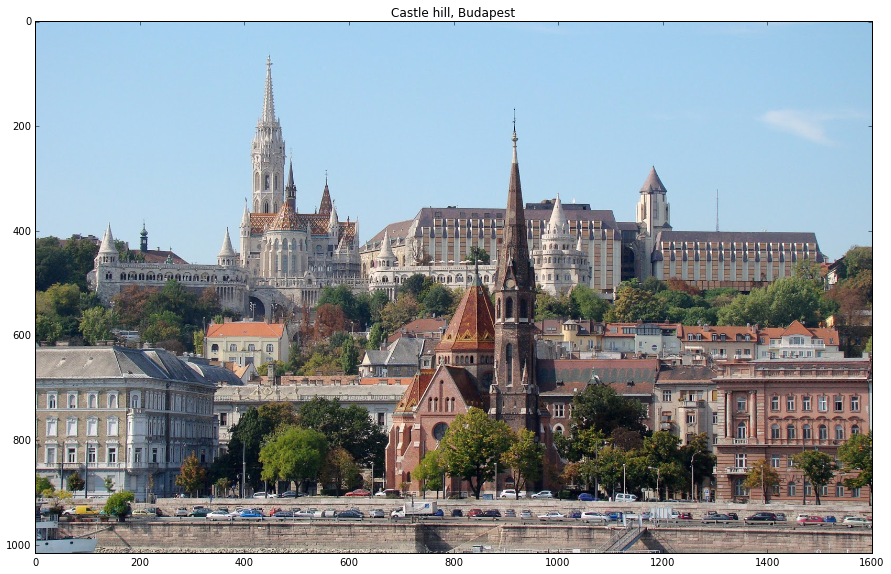

In [75]:
fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image)
a.set_title('Castle hill, Budapest')
plt.show()

In [76]:
image_red = image[:, :, 0]
image_green = image[:, :, 1]
image_blue = image[:, :, 2]

In [77]:
original_bytes = image.nbytes
print "The space (in bytes) needed to store this image is", original_bytes

The space (in bytes) needed to store this image is 39014400


Now we perform the SVD-decomposition on the $3$ matrices corresponding to the different colors separately. 

In [78]:
U_r, d_r, V_r = np.linalg.svd(image_red, full_matrices=True)
U_g, d_g, V_g = np.linalg.svd(image_green, full_matrices=True)
U_b, d_b, V_b = np.linalg.svd(image_blue, full_matrices=True)

In [79]:
bytes_to_be_stored = sum([matrix.nbytes for matrix in [U_r, d_r, V_r, U_g, d_g, V_g, U_b, d_b, V_b]])
print "The matrices that we store have total size (in bytes):", bytes_to_be_stored

The matrices that we store have total size (in bytes): 86238528


Now we decide that the information that the image contains and represented in $1600$ columns can be represented with $k=50$ columns as well, but these $k$ columns will be taken from the decomposition matrices.

In [80]:
k = 50

In [81]:
U_r_k = U_r[:, 0:k]
V_r_k = V_r[0:k, :]
U_g_k = U_g[:, 0:k]
V_g_k = V_g[0:k, :]
U_b_k = U_b[:, 0:k]
V_b_k = V_b[0:k, :]

d_r_k = d_r[0:k]
d_g_k = d_g[0:k]
d_b_k = d_b[0:k]

In [82]:
compressed_bytes = sum([matrix.nbytes for matrix in 
                        [U_r_k, d_r_k, V_r_k, U_g_k, d_g_k, V_g_k, U_b_k, d_b_k, V_b_k]])
print "The compressed matrices that we store now have total size (in bytes):", compressed_bytes

The compressed matrices that we store now have total size (in bytes): 3140400


In [83]:
ratio = compressed_bytes / original_bytes
print "The compression ratio between the original image size and the total size of the compressed factors is", ratio

The compression ratio between the original image size and the total size of the compressed factors is 0.0804933562992


Let's construct the approximate matrices for each color and merge them together. We also need to correct those pixels where the intensity value is outside of the range $[0,1]$.

In [84]:
image_red_approx = np.dot(U_r_k, np.dot(np.diag(d_r_k), V_r_k))
image_green_approx = np.dot(U_g_k, np.dot(np.diag(d_g_k), V_g_k))
image_blue_approx = np.dot(U_b_k, np.dot(np.diag(d_b_k), V_b_k))

In [85]:
image_reconstructed = np.zeros((row, col, 3))

image_reconstructed[:, :, 0] = image_red_approx
image_reconstructed[:, :, 1] = image_green_approx
image_reconstructed[:, :, 2] = image_blue_approx

In [86]:
image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

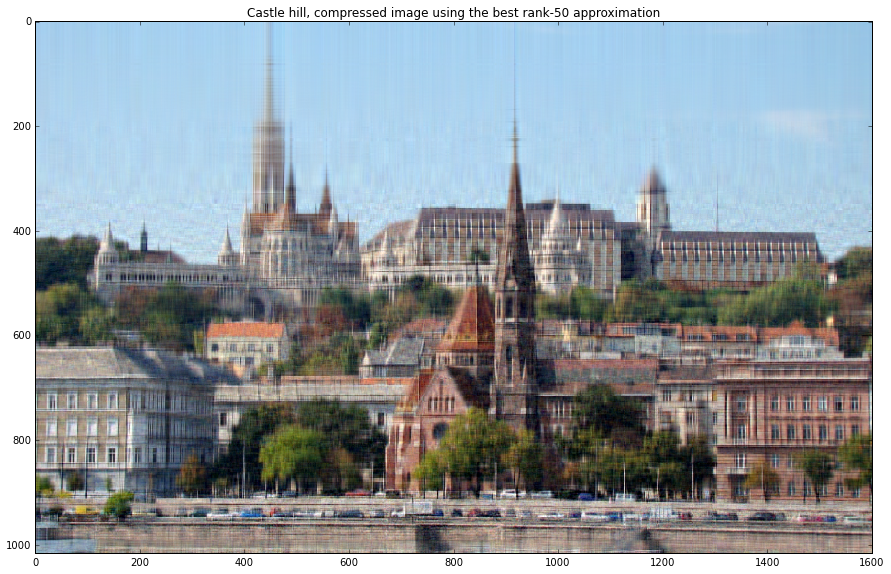

In [87]:
fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image_reconstructed)
a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
plt.show()

Different $k$'s result in different compression quality, the higher $k$ is, the closer the compressed image to the original, but increasing $k$ means larger matrixes of course. We have repeated the calculations for $k=10$ and $k=200$, we ask the reader to try the code on his/her favourite images as well. Have fun!

In [88]:
k = 10

U_r_k = U_r[:, 0:k]
V_r_k = V_r[0:k, :]
U_g_k = U_g[:, 0:k]
V_g_k = V_g[0:k, :]
U_b_k = U_b[:, 0:k]
V_b_k = V_b[0:k, :]

d_r_k = d_r[0:k]
d_g_k = d_g[0:k]
d_b_k = d_b[0:k]

image_red_approx = np.dot(U_r_k, np.dot(np.diag(d_r_k), V_r_k))
image_green_approx = np.dot(U_g_k, np.dot(np.diag(d_g_k), V_g_k))
image_blue_approx = np.dot(U_b_k, np.dot(np.diag(d_b_k), V_b_k))

image_reconstructed = np.zeros((row, col, 3))
image_reconstructed[:, :, 0] = image_red_approx
image_reconstructed[:, :, 1] = image_green_approx
image_reconstructed[:, :, 2] = image_blue_approx
image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

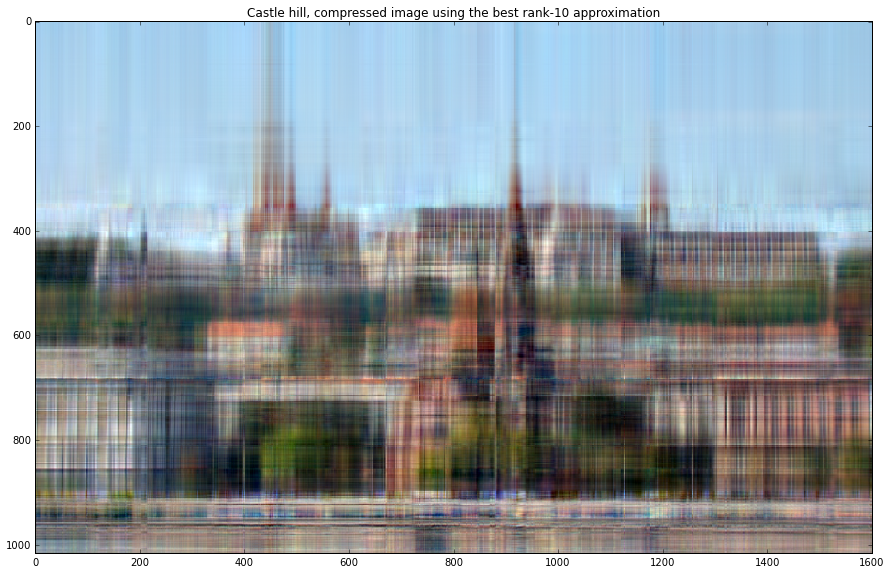

In [89]:
fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image_reconstructed)
a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
plt.show()

In [90]:
k = 200

U_r_k = U_r[:, 0:k]
V_r_k = V_r[0:k, :]
U_g_k = U_g[:, 0:k]
V_g_k = V_g[0:k, :]
U_b_k = U_b[:, 0:k]
V_b_k = V_b[0:k, :]

d_r_k = d_r[0:k]
d_g_k = d_g[0:k]
d_b_k = d_b[0:k]

image_red_approx = np.dot(U_r_k, np.dot(np.diag(d_r_k), V_r_k))
image_green_approx = np.dot(U_g_k, np.dot(np.diag(d_g_k), V_g_k))
image_blue_approx = np.dot(U_b_k, np.dot(np.diag(d_b_k), V_b_k))

image_reconstructed = np.zeros((row, col, 3))
image_reconstructed[:, :, 0] = image_red_approx
image_reconstructed[:, :, 1] = image_green_approx
image_reconstructed[:, :, 2] = image_blue_approx
image_reconstructed[image_reconstructed < 0] = 0
image_reconstructed[image_reconstructed > 1] = 1

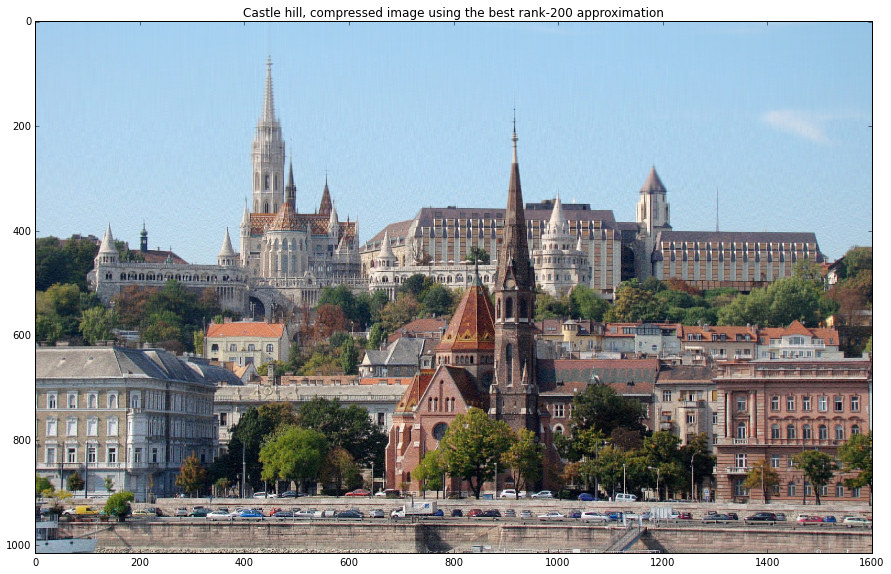

In [91]:
fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(image_reconstructed)
a.set_title('Castle hill, compressed image using the best rank-{} approximation'.format(k))
plt.show()